# 0. IMPORTS

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

import scipy.stats as SS

from sklearnex import patch_sklearn; patch_sklearn()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
import xgboost

import warnings
from kaggle.api.kaggle_api_extended import KaggleApi
from IPython.display import display, HTML
from os import remove

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## 0.1. Helper Funcions

In [143]:
def cramer_v(df1, df2):  
    confusion_matrix = pd.crosstab(df1, df2).values
    chi2 = SS.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))



def frequency_encoder(df, column):
    dict_freq = df[["ID", column]].groupby(column).count().to_dict()['ID']
    
    return df[column].apply(lambda x: dict_freq[x]/df[column].shape[0])



def precision_top_k(df, k):
    return df['Response'].head(k).sum()/k



def average_precision_at_k(df, k):
    def calc():
        for i in range(1, k + 1):
            yield precision_top_k(df, i)
            
    return np.mean(list(calc()))



def ml_result(val, k, model_name, prediction):
    df = val.copy()
    df['PropensityScore'] = prediction[:, 1]
    df = df.sort_values(by = "PropensityScore", ascending = False)

    p_at_k = precision_top_k(df, k)
    ap_at_k = average_precision_at_k(df, k)

    return pd.DataFrame([[model_name, p_at_k, ap_at_k]], columns = ['Model', "Precision@{}".format(k), "AP@{}".format(k)], index = [0])

## 0.2. Basic Settings

In [3]:
warnings.filterwarnings('ignore')

display(HTML("<style>.container { width:100% !important; }</style>"))

seed = 0

## 0.3. Loading Data

In [4]:
kaggle = KaggleApi()
kaggle.authenticate()

kaggle.dataset_download_files('anmolkumar/health-insurance-cross-sell-prediction', unzip = True);

df_raw = pd.read_csv('train.csv', encoding = 'unicode_escape')
df_final_test = pd.read_csv('test.csv', encoding = 'unicode_escape')

remove('train.csv')
remove('test.csv')
remove('sample_submission.csv')

## 0.4. Train Test Split

In [5]:
df_train_val_raw, df_test_raw = train_test_split(df_raw, train_size = 0.8, shuffle = True, random_state = seed)

# 1. DATA DESCRIPTION

In [6]:
df1 = df_train_val_raw.copy()

## 1.1. Rename Columns

In [73]:
df1.columns = ['ID', 'Gender', 'Age', 'HaveDrivingLicense', 'RegionCode',
               'HaveInsurance', 'VehicleAge', 'HaveDamagedVehicle', 'AnnualCost',
               'CommunicationChannel', 'CustomerSinceDays', 'Response']

## 1.2. Data Dimensions

In [8]:
n_rows, n_cols = df1.shape

print('Number of Rows: {}\nNumber of Columns: {}'.format(n_rows, n_cols))

Number of Rows: 304887
Number of Columns: 12


## 1.3. Data Types

In [9]:
df1.dtypes

ID                        int64
Gender                   object
Age                       int64
HaveDrivingLicense        int64
RegionCode              float64
PreviouslyInsured         int64
VehicleAge               object
HaveDamagedVehicle       object
AnnualCost              float64
CommunicationChannel    float64
CustomerSinceDays         int64
Response                  int64
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

ID                      0
Gender                  0
Age                     0
HaveDrivingLicense      0
RegionCode              0
PreviouslyInsured       0
VehicleAge              0
HaveDamagedVehicle      0
AnnualCost              0
CommunicationChannel    0
CustomerSinceDays       0
Response                0
dtype: int64

## 1.5 Fillout NA

## 1.6. Changing Data Types

In [11]:
# RegionCode
df1['RegionCode'] = df1['RegionCode'].astype('object')

# HaveDamagedVehicle
df1['HaveDamagedVehicle'] = df1['HaveDamagedVehicle'].map({'Yes': 1, 'No': 0 })

# CommunicationChannel
df1['CommunicationChannel'] = df1['CommunicationChannel'].astype('object')

## 1.7. Descriptive Analysis

In [12]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64']).drop("ID", axis = 1)
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64'])

### 1.7.1. Numerical Attributes

In [13]:
# Central Tendency
means = pd.DataFrame(num_attributes.apply(np.mean)).T
medians = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion
stds = pd.DataFrame(num_attributes.apply(np.std)).T
skews = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtoses = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
maxima = pd.DataFrame(num_attributes.apply(max)).T
minima = pd.DataFrame(num_attributes.apply(min)).T
value_range = pd.DataFrame(num_attributes.apply(lambda x: max(x) - min(x))).T

In [14]:
stats = pd.concat([minima, maxima, value_range, means, medians, stds, skews, kurtoses]).T
stats.columns = ["Min", "Max", "Range", "Mean", "Median", "Std", "Skew", "Kurtosis"]
stats

,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
Age,20.0,85.0,65.0,38.821127,36.0,15.504253,0.672074,-0.566798
HaveDrivingLicense,0.0,1.0,1.0,0.997871,1.0,0.046088,-21.605240,464.789436
PreviouslyInsured,0.0,1.0,1.0,0.458285,0.0,0.498257,0.167446,-1.971975
HaveDamagedVehicle,0.0,1.0,1.0,0.504715,1.0,0.499978,-0.018860,-1.999657
AnnualCost,2630.0,540165.0,537535.0,30578.576873,31684.0,17196.830459,1.695928,31.490580
CustomerSinceDays,10.0,299.0,289.0,154.190539,154.0,83.716529,0.005773,-1.202021
Response,0.0,1.0,1.0,0.122452,0.0,0.327807,2.303489,3.306083


### 1.7.2. Categorical Attributes

In [15]:
cat_attributes.describe().T

,count,unique,top,freq
Gender,304887,2,Male,164789
RegionCode,304887.0,53.0,28.0,85135.0
VehicleAge,304887,3,1-2 Year,160155
CommunicationChannel,304887.0,154.0,152.0,107895.0


# 2. FEATURE ENGINEERING

In [16]:
df2 = df1.copy()

## 2.1. Hypotheses

**H1.** Most of the customers who are interested in insurance are over 35 years old.

**H2.** Longer-term customers tend to be interested in insurance.

**H3.** There is a positive correlation between the car's age and the insurance cost.

**H4.** On average, men are more interested in car insurance than women.

**H5.** On average, People who have crashed their car tend to be more interested in car insurance.

**H6.** Customers tend to lose interest when the cost of insurance increases.

## 2.2. Feature Creation

# 3. VARIABLE FILTERING

In [92]:
df3 = df2.copy()

## 3.1. Row Filtering

## 3.2. Columns Filtering

In [93]:
df3 = df3.drop('ID', axis = 1)

# 4. EXPLORATORY DATA ANALYSIS

In [96]:
df4 = df3.copy()

In [128]:
df4_num = df4.select_dtypes(include = ['int64', 'float64'])
df4_cat = df4.select_dtypes(exclude = ['int64', 'float64'])
df4_cat['Response'] = df4['Response']

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

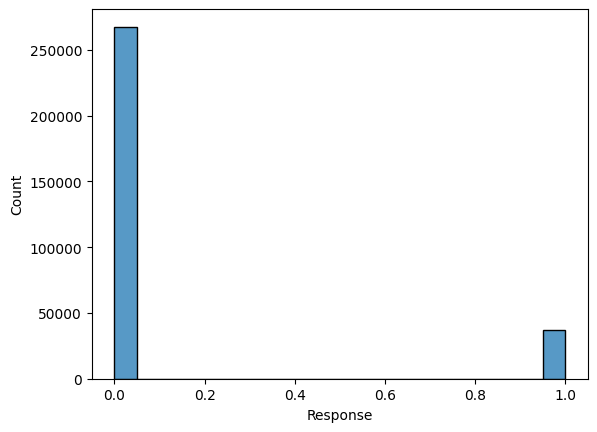

In [101]:
sns.histplot(df4["Response"]);

### 4.1.2. Numerical Attributes

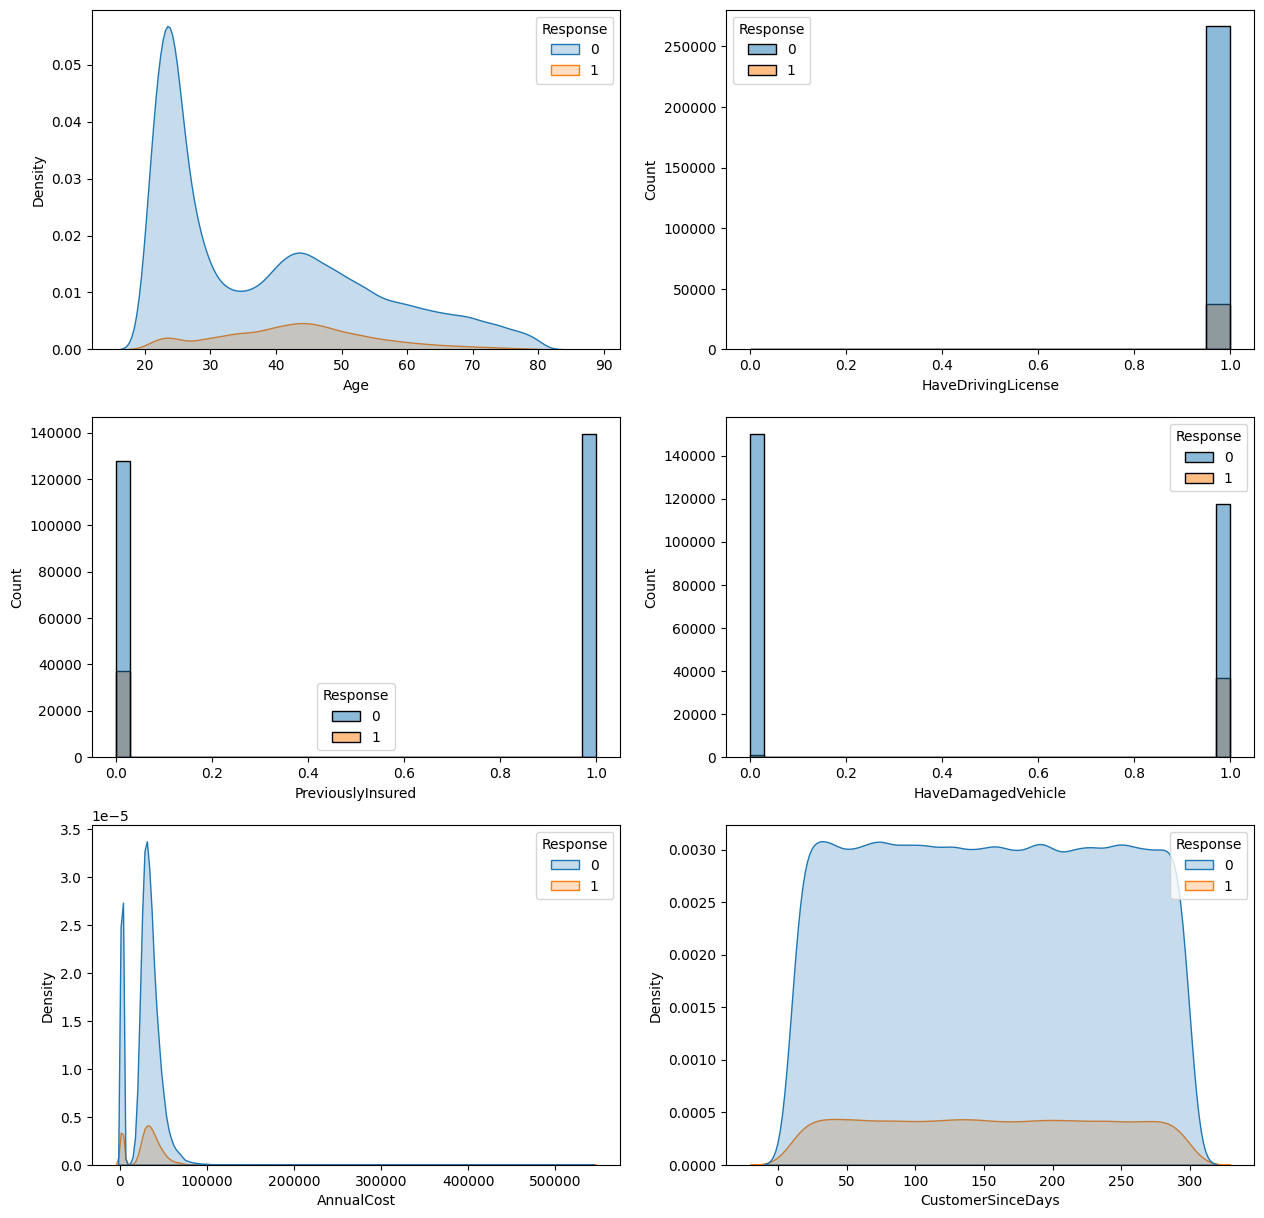

In [123]:
plt.subplots(3, 2, figsize = [15, 15])

# Age
plt.subplot(3, 2, 1)
sns.kdeplot(x = 'Age', hue = 'Response', data = df4_num, fill = True)

# HaveDrivingLicense
plt.subplot(3, 2, 2)
sns.histplot(x = "HaveDrivingLicense", hue = "Response", data = df4_num)

# PreviouslyInsured
plt.subplot(3, 2, 3)
sns.histplot(x = 'PreviouslyInsured', hue = 'Response', data = df4_num)

# HaveDamagedVehicle
plt.subplot(3, 2, 4)
sns.histplot(x = 'HaveDamagedVehicle', hue = 'Response', data = df4_num)

# AnnualCost
plt.subplot(3, 2, 5)
sns.kdeplot(x = 'AnnualCost', hue = 'Response', data = df4_num, fill = True)

# CustomerSinceDays
plt.subplot(3, 2, 6)
sns.kdeplot(x = 'CustomerSinceDays', hue = 'Response', data = df4_num, fill = True);

### 4.1.3. Categorical Attributes

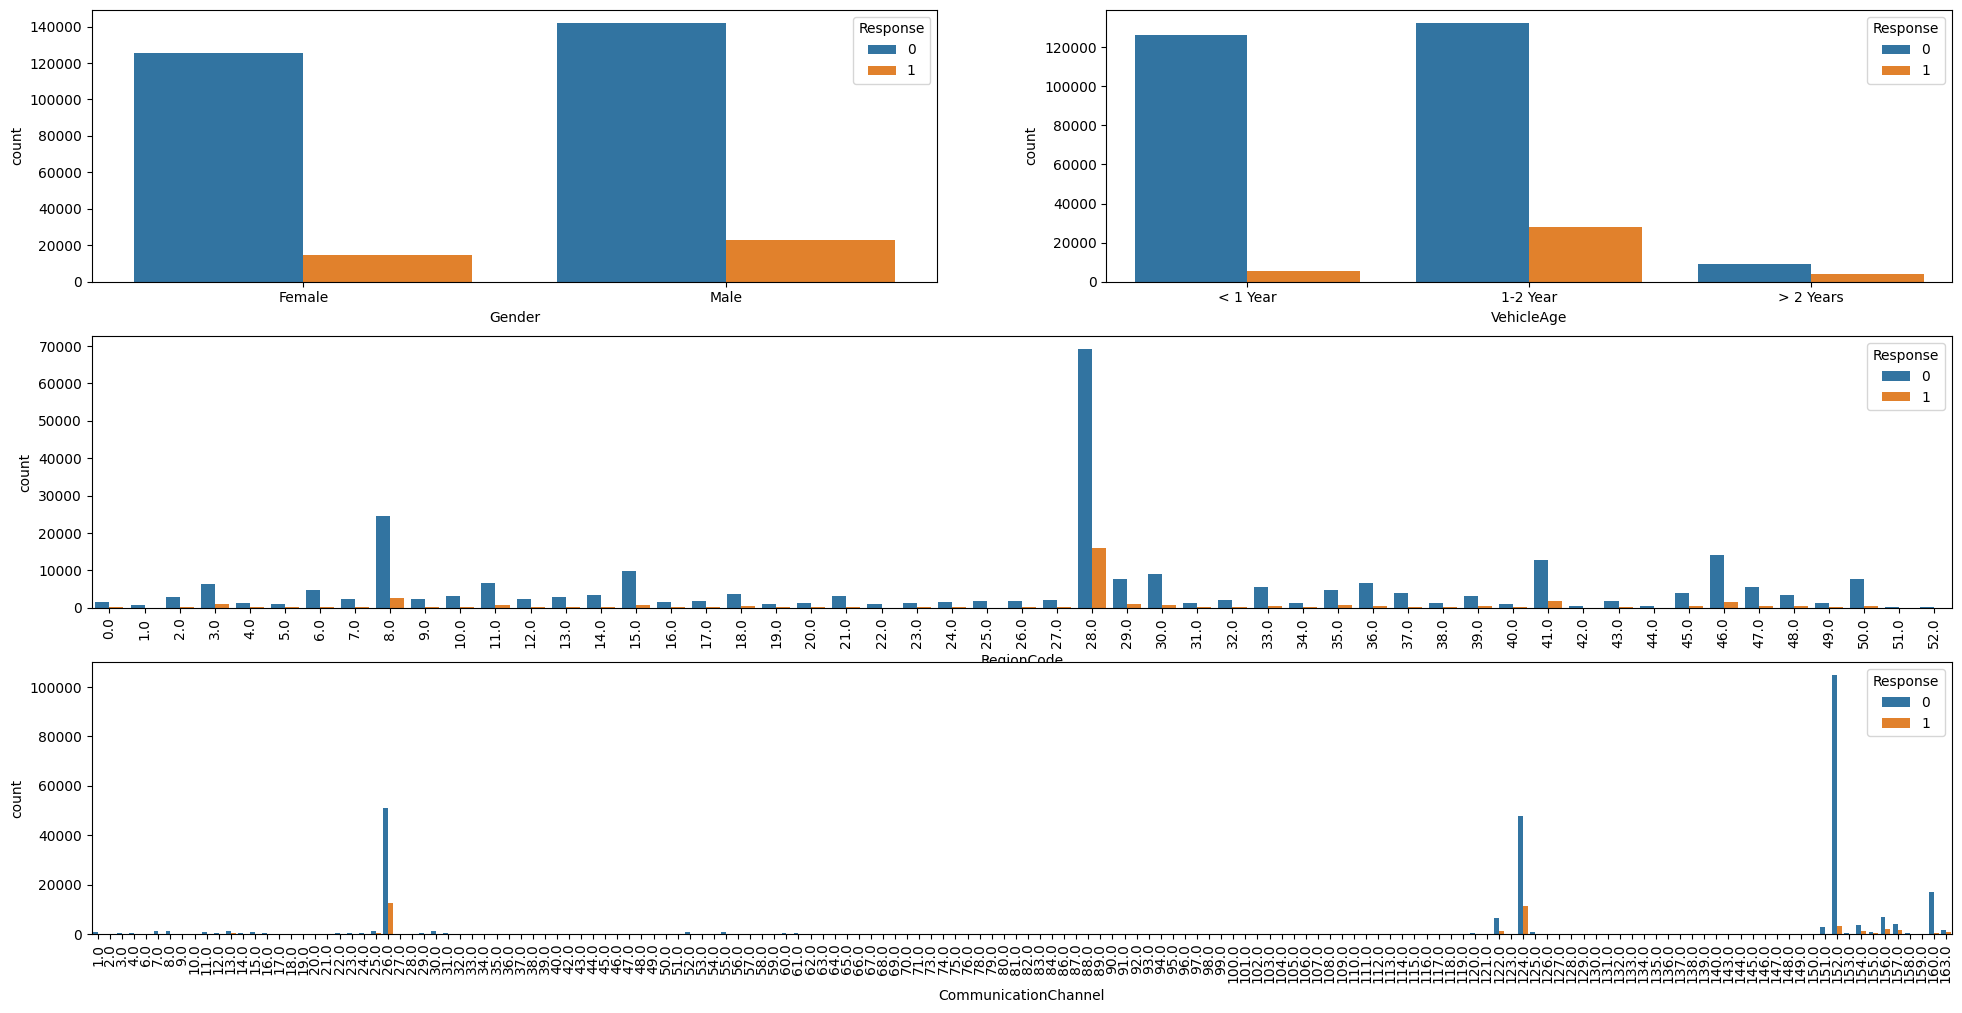

In [142]:
plt.subplots(3, 2, figsize = [24, 12])

# Gender
plt.subplot(3, 2, 1)
sns.countplot(x = 'Gender', data = df4_cat, hue = "Response")

# VehicleAge
plt.subplot(3, 2, 2)
sns.countplot(x = 'VehicleAge', data = df4_cat, hue = "Response")

# RegionCode
plt.subplot(3, 1, 2)
sns.countplot(x = 'RegionCode', data = df4_cat, hue = "Response")
plt.xticks(rotation = 90)

# CommunicationChannel
ax = plt.subplot(3, 1, 3)
ax = sns.countplot(x = 'CommunicationChannel', data = df4_cat, hue = 'Response')
plt.xticks(rotation = 90);

## 4.2. Bivariate Analysis

**H1.** Most of the customers who are interested in insurance are over 35 years old.



**H2.** Longer-term customers tend to be interested in insurance.



**H3.** There is a positive correlation between the car's age and the insurance cost.



**H4.** On average, men are more interested in car insurance than women.



**H5.** On average, People who have crashed their car tend to be more interested in car insurance.



**H6.** Customers tend to lose interest when the cost of insurance increases.

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

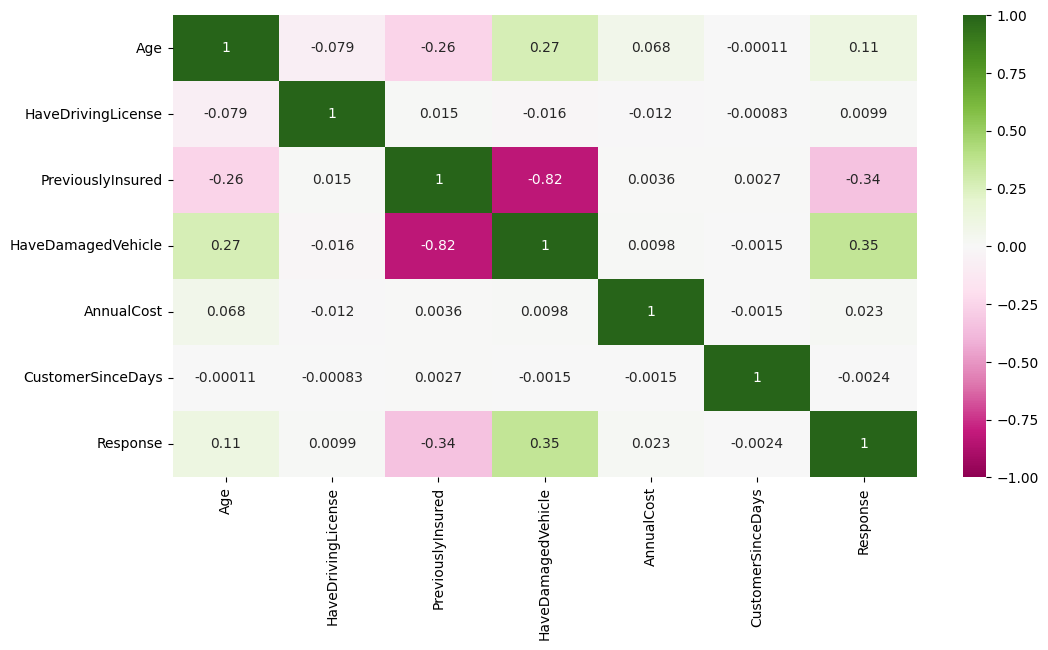

In [152]:
plt.figure(figsize = [12, 6])
sns.heatmap(df4_num.corr(), annot = True, vmin = -1, vmax = 1, cmap = "PiYG");

### 4.3.2. Categorical Attributes

In [146]:
L = df4_cat.shape[1]
cat_corr = pd.DataFrame(np.zeros([L, L]), columns = df4_cat.columns, index = df4_cat.columns)
for i in df4_cat.columns:
    for j in df4_cat.columns:
        cat_corr.loc[i, j] = cramer_v(df4[i], df4[j])

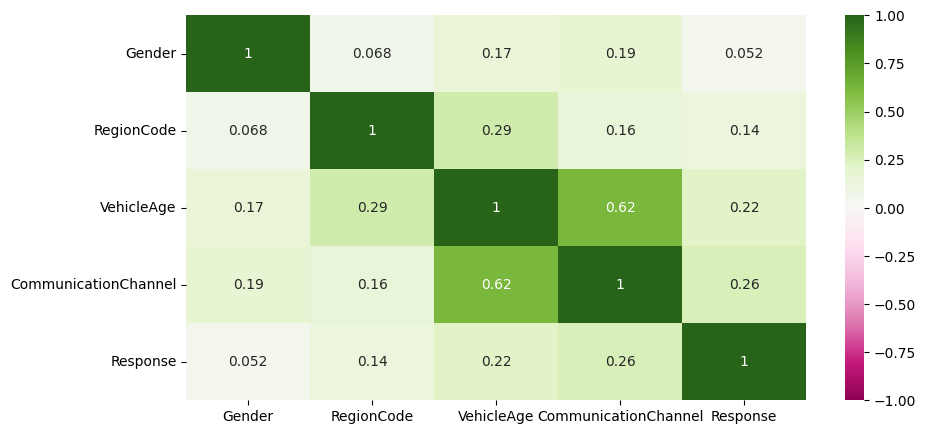

In [149]:
plt.figure(figsize = [10, 5])
sns.heatmap(cat_corr, annot = True, vmin = -1, vmax = 1, cmap = "PiYG");

# 5. DATA PREPARATION

In [19]:
df5 = df4.copy()

## 5.1. Log Transformations

In [20]:
# AnnualCost
df5['AnnualCost'] = np.log1p(df5['AnnualCost'])

## 5.2. Encoding

### 5.2.1. Label Encoding

In [21]:
# Gender
df5['Gender'] = df5['Gender'].map({'Female': -1, "Male": 1})

# VehicleAge
le_va = LabelEncoder()
df5['VehicleAge'] = le_va.fit_transform(df5['VehicleAge'])

### 5.2.2. Frequency Encoding

In [22]:
# RegionCode
df5['RegionCode'] = frequency_encoder(df5, 'RegionCode')

# CommunicationChannel
df5['CommunicationChannel'] = frequency_encoder(df5, 'CommunicationChannel')

## 5.3. Scalers

### 5.3.1. Min Max Scaler

In [23]:
# Age
mms_age = MinMaxScaler()
df5['Age'] = mms_age.fit_transform(df5[['Age']])

# CustomerSinceDays
mms_csd = MinMaxScaler()
df5['CustomerSinceDays'] = mms_csd.fit_transform(df5[['CustomerSinceDays']])

### 5.3.2. Standard Scaler

In [24]:
# AnnualCost
ss_annualcost = StandardScaler()
df5['AnnualCost'] = ss_annualcost.fit_transform(df5[['AnnualCost']])

# 6. FEATURE SELECTION

In [49]:
df6 = df5.copy()

## 6.1. Data Splitting

In [50]:
train, val = train_test_split(df6, test_size = 0.25, shuffle = True, random_state = seed)

x_train = train.drop('Response', axis = 1)
y_train = train['Response']

x_val = val.drop('Response', axis = 1)
y_val = val['Response']

## 6.2. Manual Selection

In [51]:
selected_columns_manual = ['Gender', 'Age', 'HaveDrivingLicense', 'RegionCode',
       'PreviouslyInsured', 'VehicleAge', 'HaveDamagedVehicle', 'AnnualCost',
       'CommunicationChannel', 'CustomerSinceDays', 'Response']

selected_columns_manual = ['Age']

## 6.3. Selection

In [52]:
df6 = df6.loc[:, selected_columns_manual]

# 7. MACHINE LEARNING MODELLING

In [53]:
k = 2000

## 7.1. Data Augmentation

In [54]:
smote = SMOTE(sampling_strategy = 'minority', random_state = seed, n_jobs = -1)

x_train_aug, y_train_aug = smote.fit_resample(x_train, y_train)

## 7.2. K-Nearest Neighbors

### 7.2.1. Single Model

In [55]:
knn = KNN()
knn.fit(x_train_aug, y_train_aug)

predict_knn = knn.predict_proba(x_val)

result_knn = ml_result(val, k, 'KNN', predict_knn)

result_knn

,Model,Precision@2000,AP@2000
0,KNN,0.1595,0.159316


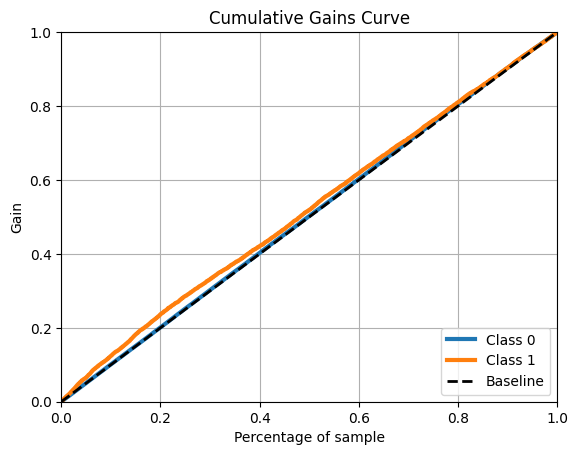

In [56]:
skplt.metrics.plot_cumulative_gain(val['Response'], predict_knn);

## 7.3. Random Forest

In [57]:
rf = RF(n_jobs = -1, random_state = seed)
rf.fit(x_train_aug, y_train_aug)

predict_rf = rf.predict_proba(x_val)

result_rf = ml_result(val, k, 'Random Forest', predict_rf)

result_rf

,Model,Precision@2000,AP@2000
0,Random Forest,0.39,0.376597


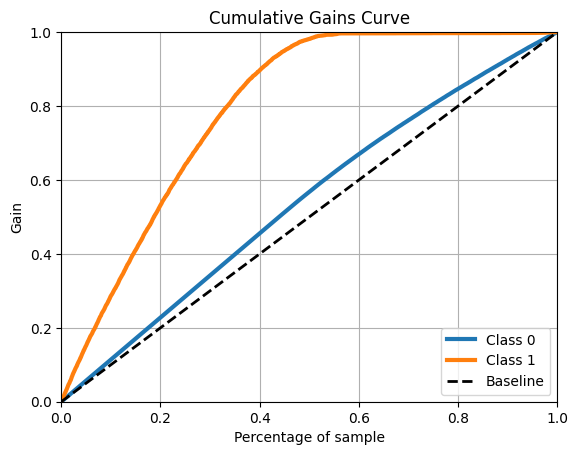

In [58]:
skplt.metrics.plot_cumulative_gain(val['Response'], predict_rf);

## 7.4. XGBoost

In [59]:
xgb = xgboost.XGBClassifier(random_state = seed)
xgb.fit(x_train_aug, y_train_aug)

predict_xgb = xgb.predict_proba(x_val)

result_xgb = ml_result(val, k, "XGBoost", predict_xgb)

result_xgb

,Model,Precision@2000,AP@2000
0,XGBoost,0.4215,0.466961


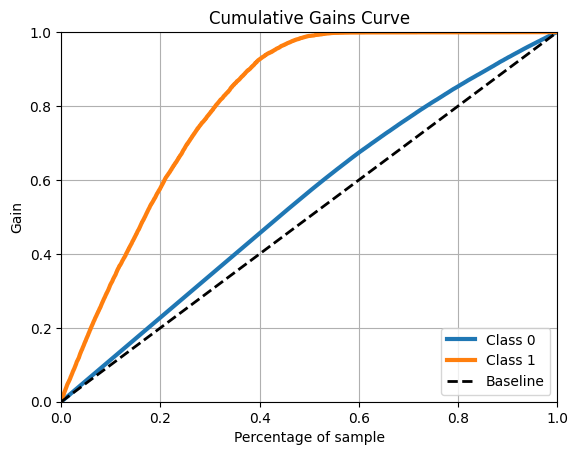

In [60]:
skplt.metrics.plot_cumulative_gain(val['Response'], predict_xgb);

## 7.5. Neural Network

## 7.6. Results

### 7.6.1. Single Model

In [61]:
pd.concat([result_knn, result_rf, result_xgb])

,Model,Precision@2000,AP@2000
0,KNN,0.1595,0.159316
0,Random Forest,0.3900,0.376597
0,XGBoost,0.4215,0.466961


# 8. HYPERPARAMETERS FINE TUNING

In [ ]:
df8 = df7.copy()

# 9. RESULT INTERPRETATION

In [ ]:
df9 = df8.copy()

# 10. DEPLOYMENT